In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import FileLink
from tqdm.notebook import trange, tqdm
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute
pd.set_option('display.max_rows', 12)


In [3]:
train_file = '/kaggle/input/hacklive-4/Train.csv'
test_file = '/kaggle/input/hacklive-4/Test.csv'
exploded_features = '/kaggle/input/df-exploded/final_features.csv'
submission_file = '/kaggle/input/hacklive-4/SampleSubmission.csv'
result_file = 'result.csv'

In [16]:
df = pd.read_csv(train_file, low_memory=False, parse_dates=['Date'])
tdf = pd.read_csv(test_file, low_memory=False, parse_dates=['Date'])
sub = pd.read_csv(submission_file, index_col='ID')
features = pd.read_csv(exploded_features, index_col="ID")
df.set_index('ID', drop=False, inplace=True)
tdf.set_index('Date', drop=True, inplace=True)
features.drop(columns=['Unnamed: 0', 'stock', 'Date', 'unpredictability_score'], inplace=True)
# df = df.rename(columns={'Date': 'date'})
# tdf = tdf.rename(columns={'Date': 'date'})
df = df.join(features)
df.set_index('Date', drop=True, inplace=True)
df.head()

,ID,stock,Open,High,Low,Close,holiday,unpredictability_score,Open__sum_values,"Low__fft_coefficient__attr_""abs""__coeff_0",...,"High__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",High__quantile__q_0.3,High__quantile__q_0.2,High__quantile__q_0.1,High__benford_correlation,High__minimum,High__maximum,High__mean,High__quantile__q_0.4,High__median
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,id_0,0,82.9961,82.7396,82.9144,82.8101,1,7,82.9961,82.9144,...,50.743488,82.7396,82.7396,82.7396,-0.272809,82.7396,82.7396,82.7396,82.7396,82.7396
2017-01-04,id_1,0,83.1312,83.1669,83.3779,82.9690,0,7,83.1312,83.3779,...,51.005548,83.1669,83.1669,83.1669,-0.272809,83.1669,83.1669,83.1669,83.1669,83.1669
2017-01-05,id_2,0,82.6622,82.7634,82.8984,82.8578,0,7,82.6622,82.8984,...,50.758085,82.7634,82.7634,82.7634,-0.272809,82.7634,82.7634,82.7634,82.7634,82.7634
2017-01-06,id_3,0,83.0279,82.7950,82.8425,82.7385,0,7,83.0279,82.8425,...,50.777465,82.7950,82.7950,82.7950,-0.272809,82.7950,82.7950,82.7950,82.7950,82.7950
2017-01-09,id_4,0,82.3761,82.0828,82.1473,81.8641,0,7,82.3761,82.1473,...,50.340679,82.0828,82.0828,82.0828,-0.272809,82.0828,82.0828,82.0828,82.0828,82.0828


In [17]:
tdf.head()

,ID,stock,holiday,unpredictability_score
Date,,,,
2019-11-01,id_713,0,0,7
2019-11-04,id_714,0,0,7
2019-11-05,id_715,0,0,7
2019-11-06,id_716,0,0,7
2019-11-07,id_717,0,0,7


In [18]:
sub.head()

,Close
ID,
id_713,85
id_714,85
id_715,85
id_716,85
id_717,85


In [19]:
def dumb_prediction(train, test, submission):
    for _, row in tqdm(test.iterrows(), total=test.shape[0]):
        stock = row['stock']
        day, month = row.name.day, row.name.month
        stockcon = train.stock == stock
        dayandmonth = (train.index.month == month) & (train.index.day == day)
        train_rows = train.loc[stockcon & dayandmonth]
        pred_sales = round(train_rows.mean()['Close'])
#         print(row['ID'])
        submission.loc[row['ID']]['Close'] = pred_sales
    return submission

In [20]:
def expand_df(dframe):
    dFrame = dframe.copy()
    dFrame['day'] = dFrame.index.day
    dFrame['month'] = dFrame.index.month
    dFrame['year'] = dFrame.index.year
    dFrame['dayofweek'] = dFrame.index.dayofweek
    dFrame['dayofyear'] = dFrame.index.dayofyear
    dFrame['weekofyear'] = dFrame.index.weekofyear
    return dFrame

In [21]:
# df_extra = extract_features(df, column_id = 'ID', column_value = 'Close',
#                             column_sort='date', show_warnings=False, impute_function=impute, n_jobs=8)
# df_extra = pd.read_csv(exploded_features, index_col='Unnamed: 0')

In [22]:
# df_extra.columns

In [23]:
data = expand_df(df)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [24]:
data

,ID,stock,Open,High,Low,Close,holiday,unpredictability_score,Open__sum_values,"Low__fft_coefficient__attr_""abs""__coeff_0",...,High__maximum,High__mean,High__quantile__q_0.4,High__median,day,month,year,dayofweek,dayofyear,weekofyear
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,id_0,0,82.9961,82.7396,82.9144,82.8101,1,7,82.9961,82.9144,...,82.7396,82.7396,82.7396,82.7396,3,1,2017,1,3,1
2017-01-04,id_1,0,83.1312,83.1669,83.3779,82.9690,0,7,83.1312,83.3779,...,83.1669,83.1669,83.1669,83.1669,4,1,2017,2,4,1
2017-01-05,id_2,0,82.6622,82.7634,82.8984,82.8578,0,7,82.6622,82.8984,...,82.7634,82.7634,82.7634,82.7634,5,1,2017,3,5,1
2017-01-06,id_3,0,83.0279,82.7950,82.8425,82.7385,0,7,83.0279,82.8425,...,82.7950,82.7950,82.7950,82.7950,6,1,2017,4,6,1
2017-01-09,id_4,0,82.3761,82.0828,82.1473,81.8641,0,7,82.3761,82.1473,...,82.0828,82.0828,82.0828,82.0828,9,1,2017,0,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-25,id_77616,102,129.7152,130.4687,130.7243,131.0068,0,6,129.7152,130.7243,...,130.4687,130.4687,130.4687,130.4687,25,10,2019,4,298,43
2019-10-28,id_77617,102,131.2933,131.5415,132.3108,131.8185,0,6,131.2933,132.3108,...,131.5415,131.5415,131.5415,131.5415,28,10,2019,0,301,44
2019-10-29,id_77618,102,131.1130,131.6313,131.7669,132.0440,0,6,131.1130,131.7669,...,131.6313,131.6313,131.6313,131.6313,29,10,2019,1,302,44


In [25]:
# dumb_pred = dumb_prediction(data, tdf, sub.copy())
# dumb_pred.fillna(0).to_csv(result_file)
# result 22.2774680735

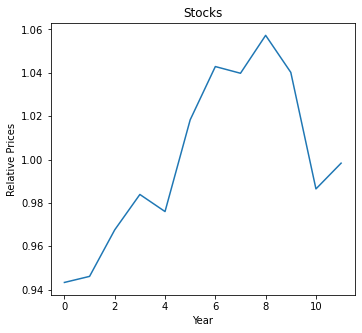

In [26]:

for stock in [0]:
    agg_year_stock = pd.pivot_table(data[data['stock'] == stock], index='month', columns='stock',
                                   values='Close', aggfunc=np.mean).values

    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(agg_year_stock / agg_year_stock.mean(0)[np.newaxis])
    plt.title("Stocks")
    plt.xlabel("Year")
    plt.ylabel("Relative Prices")
    plt.show()

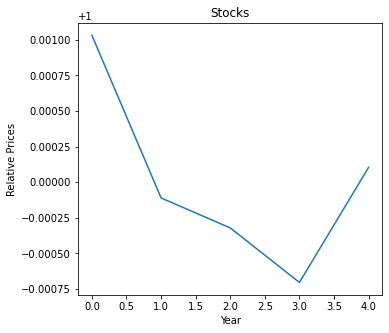

In [27]:

for stock in [0]:
    agg_year_stock = pd.pivot_table(data[data['stock'] == stock], index='dayofweek', columns='stock',
                                   values='Close', aggfunc=np.mean).values

    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(agg_year_stock / agg_year_stock.mean(0)[np.newaxis])
    plt.title("Stocks")
    plt.xlabel("Year")
    plt.ylabel("Relative Prices")
    plt.show()

In [28]:
def best_so_far(test, submission):
    for _, row in tqdm(test.iterrows(), total=test.shape[0]):
        stock = row['stock']
        day, month, year = row.name.day, row.name.month, row.name.year
        base_price = stock_table[stock]
        dayandmonth = (train.index.month == month) & (train.index.day == day)
        train_rows = train.loc[stockcon & dayandmonth]
        pred_sales = round(train_rows.mean()['Close'])
#         print(row['ID'])
        submission.loc[row['ID']]['Close'] = pred_sales
    return submission

In [29]:
data[data['stock'] == 1].shape

(713, 98)

In [30]:

import lightgbm as lgb
from sklearn.model_selection import KFold

In [31]:
params = {
    'nthread': 10,
    'max_depth': 8,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mape', # this is abs(a-e)/max(1,a)
    'num_leaves': 31,
    'learning_rate': 0.25,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.06,
    'lambda_l2': 0.1,
    'verbose': -1
}


In [ ]:
# FileLink(result_file)